# Setup Variables

MNIST, FashionMNIST, GTSRB, Cifar10

In [1]:
DATASET = 'FashionMNIST'
POSTFIX = 'Adam-32-30'
FILENAME_POSTFIX = f'{DATASET}_{POSTFIX}'
SEED = 42
CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

In [2]:
TEST_DATASET = 'MNIST'
TEST_POSTFIX = 'Adam-32-30'
TEST_FILENAME_POSTFIX = f'{TEST_DATASET}_{TEST_POSTFIX}'

In [3]:
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

In [4]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path

from fastprogress import progress_bar

from utilities.utils import *
from utilities.pathManager import fetchPaths
from utilities.MonitorUnifiedBDD import MonitorBDD

# Paths

In [23]:
paths = fetchPaths(base, DATASET, POSTFIX, False)

path_data = paths['data']
path_lhl = paths['lhl']
path_lhl_raw = paths['lhl_raw']
path_lhl_pca = paths['lhl_pca']


# load config file
configs = load_json(paths['configuration'])
config = configs['configuration']

# model config
model_setup = configs['model_setup']
model_config = configs['model_config']

# saved model
path_model = next(paths['saved_models'].glob('*.pth.tar'))

path_model

PosixPath('/home/ah19/runtime-monitoring/experiments/FashionMNIST/saved-models/FashionMNIST_Adam-32-30/FashionMNIST_Adam-32-30-acc-0.926-loss-0.209.pth.tar')

In [9]:
test_paths = fetchPaths(base, TEST_DATASET, TEST_POSTFIX, False)

test_path_data = test_paths['data']
test_path_lhl = test_paths['lhl']
test_path_lhl_raw = test_paths['lhl_raw']
test_path_lhl_pca = test_paths['lhl_pca']

# Get LHL Data for the Test Dataset

In [10]:
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn

In [11]:
from models.mnist_model import MNIST_Model
from models.fashionmnist_model import FashionMNIST_CNN
from models.gtsrb_model import GTSRB_CNN
from models.cifar10_dla import Cifar10_DLA

from models.transformers import transformers

models = {
    'mnist': MNIST_Model,
    'fashionmnist': FashionMNIST_CNN,
    'gtsrb': GTSRB_CNN,
    'cifar10': Cifar10_DLA    
}

model_ = models[DATASET.lower()]
transformer = transformers[DATASET.lower()]

In [12]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

In [13]:
feature_names = get_labels(TEST_DATASET)

train_data = get_dataset(TEST_DATASET, test_path_data, train=True, transform=transformer['train'])
test_data = get_dataset(TEST_DATASET, test_path_data, train=False, transform=transformer['test'])
len(train_data), len(test_data)

(60000, 10000)

In [14]:
feature_names

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

In [15]:
trainloader = get_dataLoader(train_data, model_config['batch_size'], True)
testloader = get_dataLoader(test_data, model_config['batch_size'], False)

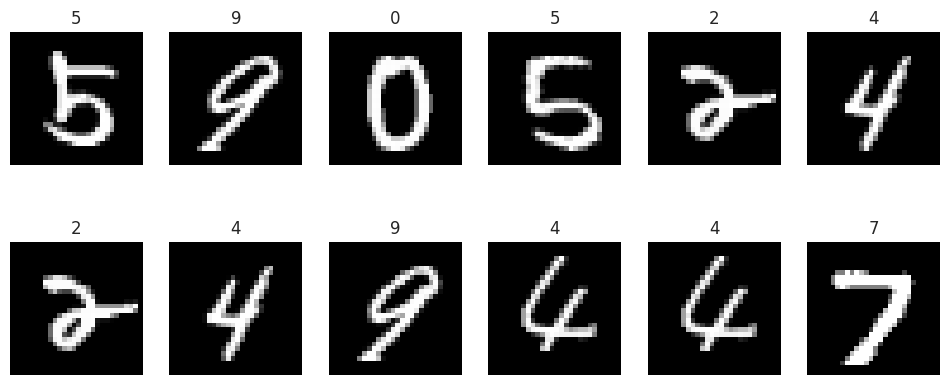

In [16]:
show_images_loader(trainloader, feature_names=feature_names)

In [42]:
# torch 2.0 compile and parallel data training
model_setup['last_hidden_neurons'] = 30
model = model_(**model_setup).to(device)
model = torch.compile(model)

# load model weights
model.load_state_dict(torch.load(path_model)['model'])

# eavluation mode
model.eval()

''

''

In [68]:
assert (len(trainloader) * model_config['batch_size']) == len(train_data)

In [52]:
res = torch.zeros((len(trainloader), model_config['batch_size'], 30))

res.shape

torch.Size([1875, 32, 30])

In [58]:
res[0].shape

torch.Size([32, 30])

In [67]:
for i, (x, _) in enumerate(trainloader):
    x = x.to(device)
    logits, _ = model.output_last_layer(x)
    res[i] = logits

In [104]:
(res.reshape([len(train_data), 30])[:32] == res[0]).all()

tensor(True)

# Seed

In [17]:
np.random.seed(SEED)

# Import Data

In [18]:
FLAVOR = 'raw'

if FLAVOR == 'raw':
    path_lhl = path_lhl_raw
else: path_lhl = path_lhl_pca

# import Data
df_train = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_train.csv")

# select only true classified
df_true = df_train[df_train["true"] == True].copy()
df_true = df_true.drop("true", axis=1).reset_index(drop=True)

df_test = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_test.csv")

# Shuffel and Split indecies

In [19]:
periods = 5

# shuffle data
schuffled_index = df_true.index.to_numpy().copy()
np.random.shuffle(schuffled_index)

# split data into batches
fragments_index = np.array_split(schuffled_index, periods)

# print shape
schuffled_index.shape, np.concatenate(fragments_index).shape

((57816,), (57816,))

# Build BDD

In [20]:
# each set of data has its own threshold
thld_p = 0.9
eta = 0
neurons = []


# save scores and stats
stats = pd.DataFrame()
train_scores = pd.DataFrame()
test_scores = pd.DataFrame()

# progress bar
pb = progress_bar(range(len(fragments_index)))

# buidl for each fragment
for fragment in pb:
    # indecies
    ix = np.concatenate(fragments_index[0:fragment+1])

    # calculate threshold
    thld = np.quantile( df_true.loc[ix].drop('y', axis=1), thld_p)
    
    # BDD
    patterns = MonitorBDD( df_true.loc[ix].shape[1]-1, thld, neurons=neurons)
    df_train_copy, df_test_copy = patterns.add_dataframe( df_true.loc[ix], eta, eval_dfs=[df_train.loc[ix].copy(), df_test.copy()] )

    
    # score
    df_train_scores = patterns.score_dataframe_multi_eta(df_train_copy, eta)
    df_test_scores = patterns.score_dataframe_multi_eta(df_test_copy, eta)

    
    # add metadata
    patterns.stats['thld'] = f'qth_{thld_p}'
    patterns.stats['period'] = fragment
    patterns.stats['num_observations'] = ix.shape[0]
    df_train_scores['period'] = fragment
    df_train_scores['num_observations'] = ix.shape[0]
    df_test_scores['period'] = fragment
    df_test_scores['num_observations'] = ix.shape[0]
    
    
    # collect scores
    stats = pd.concat([stats, patterns.stats])
    train_scores = pd.concat([train_scores, df_train_scores])
    test_scores = pd.concat([test_scores, df_test_scores])

In [21]:
stats

,thld,eta,build_time,size_mb,reorder_time,num_reorder,num_neurons,start_time,end_time,period,num_observations
1,qth_0.9,0.0,0.029,4306.823,0.0,0.0,60.0,2023-07-02 14:39:27,2023-07-02 14:39:29,0,11564
1,qth_0.9,0.0,0.055,4307.610,0.0,0.0,60.0,2023-07-02 14:39:34,2023-07-02 14:39:38,1,23127
1,qth_0.9,0.0,0.078,4307.815,0.0,0.0,60.0,2023-07-02 14:39:44,2023-07-02 14:39:49,2,34690
1,qth_0.9,0.0,0.103,4308.310,0.0,0.0,60.0,2023-07-02 14:39:57,2023-07-02 14:40:03,3,46253
1,qth_0.9,0.0,0.135,4308.419,0.0,0.0,60.0,2023-07-02 14:40:13,2023-07-02 14:40:21,4,57816


In [22]:
train_scores.loc[ train_scores['y'] == 'all' ]

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta,period,num_observations
10,all,11564.0,1702.0,57.0,1645.0,0.147181,0.033490,0.966510,0,0,11564
10,all,23127.0,1838.0,72.0,1766.0,0.079474,0.039173,0.960827,0,1,23127
10,all,34690.0,1556.0,88.0,1468.0,0.044854,0.056555,0.943445,0,2,34690
10,all,46253.0,975.0,102.0,873.0,0.021080,0.104615,0.895385,0,3,46253
10,all,57816.0,102.0,102.0,0.0,0.001764,1.000000,0.000000,0,4,57816


In [23]:
test_scores.loc[ test_scores['y'] == 'all' ]

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta,period,num_observations
10,all,10000.0,1773.0,100.0,1673.0,0.1773,0.056402,0.943598,0,0,11564
10,all,10000.0,1280.0,70.0,1210.0,0.1280,0.054688,0.945312,0,1,23127
10,all,10000.0,1030.0,54.0,976.0,0.1030,0.052427,0.947573,0,2,34690
10,all,10000.0,879.0,51.0,828.0,0.0879,0.058020,0.941980,0,3,46253
10,all,10000.0,760.0,42.0,718.0,0.0760,0.055263,0.944737,0,4,57816
